In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.manual_seed(1337)

In [3]:
with open("../data/input.txt","r",encoding='utf-8') as f:
    text = f.read()

In [4]:
len(text)

1115394

In [5]:
chars = sorted(list(set("".join(text))))
vocab_size = len(chars)

In [6]:
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}
encode = lambda s:[stoi[c] for c in s]
decode = lambda s:[itos[c] for c in s]

In [7]:
data = torch.tensor(encode(text))
data[:100]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])

In [8]:
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

In [9]:
batch_size = 4 # how many sequences to process paralelly
context_len = 10 # how many tokens to see at a time to predict the next token
def get_batch(split):
    ix = torch.randint(len(split) - context_len, (batch_size,))
    x = torch.stack([split[i:i+context_len] for i in ix])
    y = torch.stack([split[i+1:i+context_len+1] for i in ix])
    return x,y
train_Xb,train_Yb = get_batch(train_data)
val_Xb, val_Yb = get_batch(val_data)

In [10]:
class BigramLanguageModel(nn.Module):
    def __init__(self,vocab_size):
        super().__init__()
        self.lookup_table = nn.Embedding(vocab_size,vocab_size)

    def forward(self,idx,targets=None):
        logits = self.lookup_table(idx)
        B, T, C = logits.shape
        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits.view(B*T,C),targets.view(B*T))
        return logits,loss

    def generate(self,idx,max_new_tokens):
        for _ in range(max_new_tokens):
            logits,loss = self(idx)
            logits = logits[:,-1,:] # the whole batch, the next token and the whole vocab size
            probs = F.softmax(logits,dim=-1) # this gives us the probabilities
            idx_next = torch.multinomial(probs,num_samples=1)
            idx = torch.cat([idx, idx_next],dim=1)
        return idx


model = BigramLanguageModel(vocab_size=vocab_size)
logits,loss = model(train_Xb,train_Yb)
print(logits.shape,loss)

torch.Size([4, 10, 65]) tensor(4.8025, grad_fn=<NllLossBackward0>)


In [11]:
print("".join(decode(model.generate(torch.zeros((1,1),dtype=torch.long),100)[0].tolist())))


VMPFsPHSYAHIkPXroxdH.ACNM?''sBym,SG?Um-FhLZkRNsg$PrIPyXMDqA'XH.VsaT.fKxhQCWWsjkHMhsRSUaN$j?WTcK3MHMF


In [15]:
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)
losses = list()

In [16]:
batch_size = 32
for epoch in range(100000):
    xb,yb = get_batch(train_data)

    logits,loss = model(xb,yb)
    optimiser.zero_grad(set_to_none=True)
    losses.append(loss.item())
    loss.backward()
    optimiser.step()

    if epoch%10000 == 0:
        print(f"{len(losses) + epoch}:{loss.item()}")
print(f"10000: {loss.item()}")


1:3.4757068157196045
20001:2.8265223503112793
40001:2.650009870529175
60001:2.515174150466919
80001:2.624943733215332
100001:2.4983177185058594
120001:2.4779529571533203
140001:2.4902050495147705
160001:2.449042797088623
180001:2.4657363891601562
10000: 2.4374592304229736


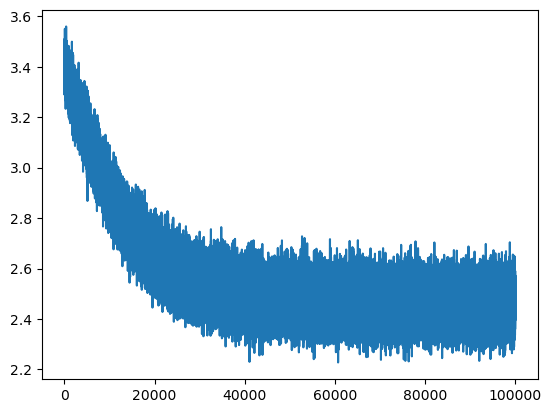

In [17]:
plt.plot(losses)

In [18]:
print("".join(decode(model.generate(torch.zeros((1,1),dtype=torch.long),300)[0].tolist())))



CHes t
LI n ld we f fiourdo whouathase:
And IUS:
I hace pitife agrdis youre, yoroumout ofoweayound.
MIN por the!
TANG y
SSThute fe irvine bl d'ly hed!
moth meehe s! mtyousou.


weavUCon horthoville,

We wint, in?'shicimille:
WAfod,
TI th thendsthe is.
TIn tofry helenderllowhe t tl't w,
MENG eange p


In [19]:
torch.backends.mps.is_available()

True